In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Default plot configurations
%matplotlib inline
plt.rcParams['figure.figsize'] = (16,8)
plt.rcParams['figure.dpi'] = 150
sns.set()

from IPython.display import display, Latex, Markdown

## Background

The US president is chosen by the Electoral College, not by popular vote. 
Each state is alotted a certan number of electoral college votes, as a function of their population, and
typically, whomever wins the popular vote in the state receives all of the electoral college votes for that state. 

In advance of the election, polls are conducted separately in all of the states.
The results help identify "battleground" states, and they are combined to predict the winner of the electoral college votes.
In 2016, pollsters correctly predicted the election outcome in 46 of the 50 states. 
For those 46 states Trump received 231 and Clinton received 232 electoral college votes.
The remaining 4 states, Florida, Michigan, Pennsylvania, and Wisconsin, accounted for a total of 75 votes, and 
whichever candidate received the majority of the electoral college votes in these states would win the election. 


The electoral margins in these four states were narrow, e.g., in Pennsylvania Trump received 48.18% and Clinton received 47.46% of the 6,165,478 votes cast in the state. 
Such narrow margins can make it hard to predict the outcome given the sample sizes that the polls used.

Many experts have studied the 2016 election results. 
According to the American Association for Public Opinion Research (AAPOR),
one online, opt-in poll adjusted their polling results for education but used only three broad categories 
(high school or less, some college, and college graduate). 
They found that had they separated out those with advanced degrees from those with college 
degrees, then they would have reduced Clinton’s margin by 0.5 percentage points. 
In other words, after the fact they were able to identify an education bias where highly educated voters tended to be more willing to participate in polls. This bias matters because these voters also tended to prefer Clinton over Trump.

Now that we know how people actually voted, we can carry out a simulation study that imitates the election polling under different scenarios to help develop intuition for accuracy, bias, and variance. 
We will simulate the polls for Pennsylvania under two scenarios: 

1. People surveyed didn't change their minds, didn't hide who they voted for, and were representative of those who voted on election day.
2. People with a higher education were more likely to respond, which led to a 0.5% bias for Clinton.

Our ultimate goal is to understand the chance that a poll incorrectly calls the election for Hillary Clinton even if our sample was collected with absolutely no bias, and when there is a small amount of non-response bias.

---
## Simulation Study of the Sampling Error


For the first scenario, we simulate a simple random sample (SRS) of the 6+m voters in Pennsylavania and
calculate Trump's lead over Clinton. 
We repeat this sample collection over and over, each time calculating Trump's lead, to get 
a sense of the different values a SRS might produce.

Our population consists of the votes cast for Trump, Clinton, and a third-party candidate.
We lump all of the third party candidates together because we are only interested in the difference between
votes cast for Trump and Clinton.

### The Urn Model

We can cast this problem in terms of an urn model as follows:

+ There are 6,165,478 marbles in the urn, one for each vote
+ Since we care only about whether the vote is for Clinton, Trump, or some other third party candidate, we can lump all third party candidates together and label each marble in one of three ways: Trump, Clinton, and Other.
+ The poll is a SRS of, say, 1500 marbles from the urn
+ We tally up the counts of the three types of marbles 

We begin by creating an urn that represents the votes cast on election day. 

In [2]:
proportions = np.array([0.4818, 0.4746, 1 - (0.4818 + 0.4746)])               
n = 1500
N = 6165478
votes = np.trunc(N * proportions)
votes

array([2970527., 2926135.,  268814.])

This version of the urn model is so common that there is a random chance process named for it, the multivariate hypergeometric. We can take a SRS and get our counts with the function call:

In [3]:
# I get errors trying to call this function so resorted to the multinomial below.
# Would like to update the code to the multivariate hypergeometric.
# np.random.multivariate_hypergeometric(votes, n)

In [4]:
np.random.multinomial(n, proportions)

array([721, 725,  54])

And, each time we call `np.random.multinomial` we get a different sample and counts, e.g.,

In [5]:
np.random.multinomial(n, proportions)

array([729, 702,  69])

We compute Trumnp's lead for each simulation, i.e., $(n_T - n_C)/n$, where $n_T$ are the number of Trump votes in the sample and $n_C$ the number for Clinton. If the lead is positive, then the sample shows a win for Trump.

We know the actual lead was, 0.4818 - 0.4746 =  0.0072, and to get a sense of the variation in the sampling process 
we can simulate the sampling process over and over and examine the values that we get in return. 
Below we simulate 100,000 simple random samples of 1500 voters from the state of Pennsylvania.  

In [6]:
def trump_advantage(n, proportions):
    sample_votes = np.random.multinomial(n, proportions)
    return (sample_votes[0] - sample_votes[1]) / n

In [7]:
simulations = [trump_advantage(n, proportions) for i in range(100000)] 

On average, the polling results show Trump with close to a 0.7% lead: 

In [8]:
np.mean(simulations)

0.007324273333333334

However, many times the lead in the sample was negative, meaning Clinton was the winner for that sample of voters.
The histogram below shows the sampling distribution of Trump's advantage in Pennsylvania for a sample of 1500 voters. 
The vertical dashed line at 0 shows that more often than not, Trump is called, but there are many times when a sample 
shows Clinton in the lead.

Text(0.5, 0, 'Trump Lead in the Sample')

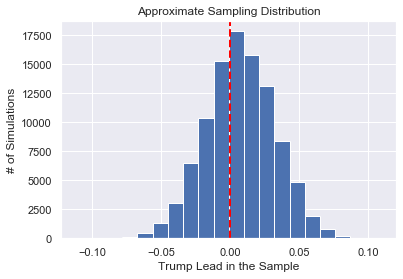

In [9]:
plt.hist(simulations, bins=20)
plt.axvline(0, color='red', linestyle='dashed', linewidth=2)
plt.title('Approximate Sampling Distribution')
plt.ylabel('# of Simulations')
plt.xlabel('Trump Lead in the Sample')

In the 100,0000 simulated polls, we find Trump a victor about 60% of the time: 

In [10]:
np.count_nonzero(np.array(simulations) > 0) / 100000

0.60891

This number represents the chance that a given sample will correctly predict Trump's victory *even if the sample was collected with absoutely no bias*. In other words, even a non-biased sample will be wrong about 40% of the time. 


We have just studied the sampling error, and found how our predictions might look if there was no bias in our 
sampling process. Next we will see what happens when a little biasenters into the mix.

---
## Simulation Study of Selection Bias


"In a perfect world, polls sample from the population of voters, who would state their political preference perfectly clearly and then vote accordingly." (REF)

That's the simulation study that we just performed. 


It's difficult to control for every source of bias. We investigate here the effect of a small, education bias on the polling results. 
Specifically, we examine the impacts of the 0.5 percent bias in favor of Clinton that we described earlier. 

This bias essentially means that we see a distorted picture of voter preferences in our polls, where instead of 47.46 percent votes for Clinton, we have 47.96, and we have 48.18 - 0.5 = 47.68 percent for Trump. 
We adjust the proportions to reflect this bias: 

In [11]:
proportions_bias = [0.4818 - 0.005, 0.4747 + 0.005, 1 - (0.4818 + 0.4746) ]
proportions_bias

[0.4768, 0.4797, 0.04359999999999997]

Now, our simulations find Trump winning in about 45% of the samples.

In [12]:
simulations_bias = [trump_advantage(n, proportions_bias) for i in range(100000)] 

Text(0.5, 0, 'Trump Lead in the Sample')

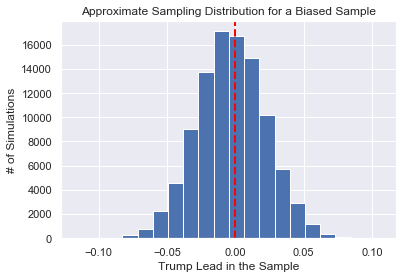

In [13]:
plt.hist(simulations_bias, bins=20)
plt.axvline(0, color='red', linestyle='dashed', linewidth=2)
plt.title('Approximate Sampling Distribution for a Biased Sample') 
plt.ylabel('# of Simulations')
plt.xlabel('Trump Lead in the Sample')

In [14]:
np.count_nonzero(np.array(simulations_bias) > 0) / 100000

0.44714

Notice that the histograms from the two simulations are similar in shape. 
They are symmetric with reasonable length tails, i.e., they appear to roughly follow the normal curve.
The second histogram is shifted slightly to the left, which reflects the non-response bias we introduced.

###  Would increasing the sample size have helped?

With our simulation study we can get insight into the answer to this question. 
For example, we can try a sample size of 12,000 and run 100,000 simulations for both scenarios.

In [15]:
simulations_big = [trump_advantage(12000, proportions) for i in range(100000)] 
simulations_bias_big = [trump_advantage(12000, proportions_bias) for i in range(100000)] 

In [16]:
scenario_no_bias = np.count_nonzero(np.array(simulations_big) > 0) / 100000
scenario_bias = np.count_nonzero(np.array(simulations_bias_big) > 0) / 100000
print(scenario_no_bias, scenario_bias)

0.78669 0.37066


By analyzing over 4,000 polls for 600 state-level, gubernatorial, senatorial, and presidential elections, Shirani-Mehr et al found that on average these polls exhibited a bias of about 1.5 percentage points.

When the margin of victory is relatively small as it was in 2016, a larger sample size reduces the sampling error, but unfortunately, if there is bias, then the predictions are close to the biased estimate. If the bias pushes the prediction from one candidate (Trump) to another (Clinton), then we have a "surprise" upset. 

### References

M. Grotenhuis, S. Subramanian, R. Nieuwenhuis, B. Pelzer and R. Eisinga (2018) Better poll sampling would have cast more doubt on the potential for Hillary Clinton to win the 2016 election. (https://blogs.lse.ac.uk/usappblog/2018/02/01/better-poll-sampling-would-have-cast-more-doubt-on-the-potential-for-hillary-clinton-to-win-the-2016-election/#Author)


H. Shirani-Mehr, D. Rothschild, S. Goel and A. Gelman (2018) Disentangling Bias and Variance in Election Polls. Journal of the American Statistical Association, vol 113, no 522, https://doi.org/10.1080/01621459.2018.1448823